## **1. Instalación**

In [ ]:
!pip install missingno

## **2. Importaciones**

In [ ]:
import missingno as msno
import math
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd
from joblib import dump
import numpy as np

## **3. Abrir Dataset**

In [ ]:

tickers = [
    "AAPL",   # Apple
    "MSFT",   # Microsoft
    "NVDA",   # NVIDIA
    "MU",     # Micron Technology
    "IBM",    # IBM
    "ORCL",   # Oracle
    "PLTR",   # Palantir Technologies
    "GOOGL",  # Alphabet (Google)
    "META",   # Meta Platforms (Facebook / Instagram)
    "NFLX",   # Netflix
    "AMZN",   # Amazon
    "TSLA",   # Tesla
    "NKE",    # Nike
    "MMM",    # 3M
    "CAT",    # Caterpillar
    "JNJ",    # Johnson & Johnson
    "XOM",    # Exxon Mobil
    "CVX",    # Chevron
    "PFE",     # Pfizer
    "UAA",    # UnderArmour
    "VFC"      # NorthFace
]

df = yf.download(
    tickers,
    start="2014-01-03",
    end="2025-12-31",
      group_by="ticker"
)

# Pasar de columnas anchas → filas
df = (
    df.stack(level=0)
      .reset_index()
      .rename(columns={"Ticker": "ticker",
                      })
)
df = df.rename(columns={
    "Open": "precio_apertura",
    "High": "precio_maximo",
    "Low": "precio_minimo",
    "Close": "precio_cierre",
    "Volume": "volumen",
})

df.columns.name = None




/tmp/ipython-input-1485941720.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  21 of 21 completed
/tmp/ipython-input-1485941720.py:34: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df.stack(level=0)


In [ ]:
df

,Date,ticker,precio_apertura,precio_maximo,precio_minimo,precio_cierre,volumen
0,2014-01-03,AAPL,17.148328,17.174382,16.762780,16.779840,392467600.0
1,2014-01-03,AMZN,19.914499,20.135500,19.811001,19.822001,44204000.0
2,2014-01-03,CAT,65.986565,66.169861,65.685957,65.854591,3722000.0
3,2014-01-03,CVX,75.030234,75.204864,74.584631,74.879692,3506000.0
4,2014-01-03,GOOGL,27.693657,27.741593,27.443546,27.445284,66601332.0
...,...,...,...,...,...,...,...
61634,2025-12-30,PLTR,184.350006,184.729004,180.699997,180.839996,23336300.0
61635,2025-12-30,TSLA,461.089996,463.119995,453.829987,454.429993,59238500.0
61636,2025-12-30,UAA,4.910000,5.200000,4.910000,5.140000,29989000.0
61637,2025-12-30,VFC,18.180000,18.320000,18.070000,18.260000,4873700.0


## **4. Incluir Variables Exógenas**

In [ ]:
exo = yf.download(
    [
        "ALI=F",
        "NG=F",
        "^TNX",
        "^IRX",
        "^FVX",
        "DX-Y.NYB",
        "CL=F",
        "GC=F",
        "HG=F",
        "SI=F",
        "EURUSD=X",
        "JPY=X",
        "CNY=X",
        "^GSPC",   # ← S&P 500
        "^VIX"     # ← Volatilidad
    ],
    start="2014-01-03",
    end="2025-12-31",
    progress=False
)["Close"]

exo = exo.rename(columns={
    # Tasas e índices
    "^TNX": "tasa_tesoro_10y",
    "^IRX": "tasa_tesoro_3m",
    "^FVX": "tasa_tesoro_5y",
    "^GSPC": "sp500",
    "^VIX": "volatilidad",

    # Monedas (USD como base)
    "DX-Y.NYB": "dxy",
    "EURUSD=X": "usd_eur",
    "JPY=X": "yen",
    "CNY=X": "yuan",

    # Commodities (en USD)
    "CL=F": "petroleo_usd",
    "NG=F": "gas_natural_usd",
    "GC=F": "oro_usd",
    "HG=F": "cobre_usd",
    "ALI=F": "aluminio_usd",
    "SI=F": "plata_usd",
})




/tmp/ipython-input-1438115884.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  exo = yf.download(


## **5. Conocer la Naturaleza de las variables**

In [ ]:
exo_tickers = [
    "ALI=F",
    "NG=F",
    "^TNX",
    "^IRX",
    "^FVX",
    "DX-Y.NYB",
    "CL=F",
    "GC=F",
    "HG=F",
    "SI=F",
    "EURUSD=X",
    "JPY=X",
    "CNY=X",
    "^GSPC",
    "^VIX"
]
info_list = []

for t in exo_tickers:
    ticker = yf.Ticker(t)
    info = ticker.info

    info_list.append({
        "ticker": t,
        "shortName": info.get("shortName"),
        "longName": info.get("longName"),
        "currency": info.get("currency"),
        "quoteType": info.get("quoteType")
    })

exo_info = pd.DataFrame(info_list)
exo_info

,ticker,shortName,longName,currency,quoteType
0,ALI=F,"Aluminum Futures,Apr-2026",None,USD,FUTURE
1,NG=F,Natural Gas Mar 26,None,USD,FUTURE
2,^TNX,CBOE Interest Rate 10 Year T No,CBOE Interest Rate 10 Year T No,USD,INDEX
3,^IRX,13 WEEK TREASURY BILL,13 WEEK TREASURY BILL,USD,INDEX
4,^FVX,Treasury Yield 5 Years,Treasury Yield 5 Years,USD,INDEX
5,DX-Y.NYB,ICE US Dollar Index - Index - C,US Dollar Index,USD,INDEX
6,CL=F,Crude Oil Mar 26,None,USD,FUTURE
7,GC=F,Gold Apr 26,None,USD,FUTURE
8,HG=F,Copper Mar 26,None,USD,FUTURE
9,SI=F,Silver Mar 26,None,USD,FUTURE


## **6. Convertir todo en Dolares**

In [ ]:
exo_final = exo.copy()
exo_final["usd_yen"]  = 1 / exo["yen"]        # Paso de Yenes sobre un Dolar a Dolares sobre un Yen
exo_final["usd_yuan"] = 1 / exo["yuan"]        # Paso de Yuanes sobre un Dolar a Dolares sobre un Yuan
cols_retornos = ["sp500", "volatilidad"]

# Calcular retornos SOLO para esas columnas
exo_final[cols_retornos] = (
    exo[cols_retornos]
    .pct_change()
    .shift(1)
)


/tmp/ipython-input-486713904.py:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


## **7. Unir Dataset original con Dataset de Variables Exógenas**

In [ ]:
df = df.merge(
    exo_final.reset_index(),
    on="Date",
    how="left"
)
df.drop('yen', axis=1, inplace=True)
df.drop('yuan', axis=1, inplace=True)

In [ ]:
df.head(40)

,Date,ticker,precio_apertura,precio_maximo,precio_minimo,precio_cierre,volumen,aluminio_usd,petroleo_usd,dxy,...,cobre_usd,gas_natural_usd,plata_usd,tasa_tesoro_5y,sp500,tasa_tesoro_3m,tasa_tesoro_10y,volatilidad,usd_yen,usd_yuan
0,2014-01-03,AAPL,17.148328,17.174382,16.762780,16.779840,392467600.0,NaN,93.959999,80.790001,...,3.406,4.304,20.181999,1.727,NaN,0.058,2.995,NaN,0.009539,0.165544
1,2014-01-03,AMZN,19.914499,20.135500,19.811001,19.822001,44204000.0,NaN,93.959999,80.790001,...,3.406,4.304,20.181999,1.727,NaN,0.058,2.995,NaN,0.009539,0.165544
2,2014-01-03,CAT,65.986565,66.169861,65.685957,65.854591,3722000.0,NaN,93.959999,80.790001,...,3.406,4.304,20.181999,1.727,NaN,0.058,2.995,NaN,0.009539,0.165544
3,2014-01-03,CVX,75.030234,75.204864,74.584631,74.879692,3506000.0,NaN,93.959999,80.790001,...,3.406,4.304,20.181999,1.727,NaN,0.058,2.995,NaN,0.009539,0.165544
4,2014-01-03,GOOGL,27.693657,27.741593,27.443546,27.445284,66601332.0,NaN,93.959999,80.790001,...,3.406,4.304,20.181999,1.727,NaN,0.058,2.995,NaN,0.009539,0.165544
5,2014-01-03,IBM,109.848047,110.746552,109.534749,110.326859,4250107.0,NaN,93.959999,80.790001,...,3.406,4.304,20.181999,1.727,NaN,0.058,2.995,NaN,0.009539,0.165544
6,2014-01-03,JNJ,65.401354,66.067618,65.379863,65.802544,5637600.0,NaN,93.959999,80.790001,...,3.406,4.304,20.181999,1.727,NaN,0.058,2.995,NaN,0.009539,0.165544
7,2014-01-03,META,54.638338,55.263969,54.151736,54.181530,38246200.0,NaN,93.959999,80.790001,...,3.406,4.304,20.181999,1.727,NaN,0.058,2.995,NaN,0.009539,0.165544
8,2014-01-03,MMM,79.139689,79.431380,78.945230,79.185448,2551427.0,NaN,93.959999,80.790001,...,3.406,4.304,20.181999,1.727,NaN,0.058,2.995,NaN,0.009539,0.165544
9,2014-01-03,MSFT,30.864316,30.880911,30.366503,30.623707,31134800.0,NaN,93.959999,80.790001,...,3.406,4.304,20.181999,1.727,NaN,0.058,2.995,NaN,0.009539,0.165544


## **8. Entender las Variables**

In [ ]:
categoricas = ["ticker"]
fechas = ["Date"]

precios = [
    "precio_apertura", "precio_maximo",
    "precio_minimo", "precio_cierre"
]

volumen = ["volumen"]

macros_continuas = [
    "aluminio_usd", "petroleo_usd", "dxy", "cobre_usd",
    "gas_natural_usd", "plata_usd", "sp500",
    "usd_yen", "usd_yuan", "volatilidad"
]

tasas = [
    "tasa_tesoro_3m", "tasa_tesoro_5y", "tasa_tesoro_10y"
]




In [ ]:
df["ticker"].value_counts(normalize=True) * 100
df[precios].describe()
df[macros_continuas].describe()
df["volumen"].describe()
np.log(df["volumen"]).describe()
df[tasas].diff().describe()

,tasa_tesoro_3m,tasa_tesoro_5y,tasa_tesoro_10y
count,61617.000000,61617.000000,61617.000000
mean,0.000056,0.000030,0.000017
std,0.006100,0.012042,0.011646
min,-0.243000,-0.342000,-0.322000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,0.245000,0.238000,0.269000


<Axes: title={'center': 'S&P500'}, xlabel='Date'>

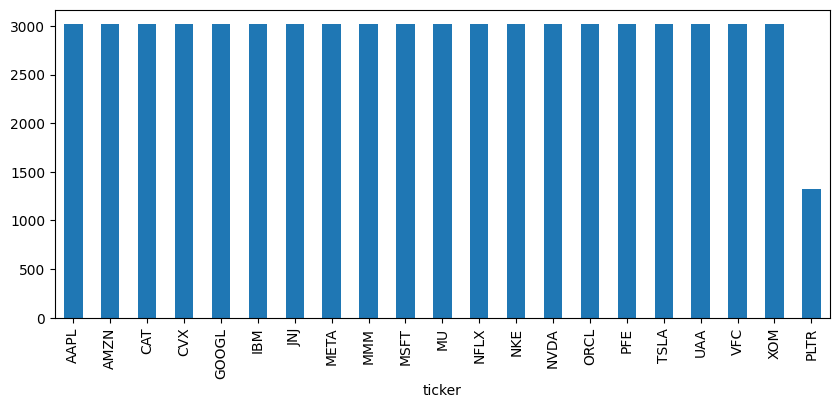

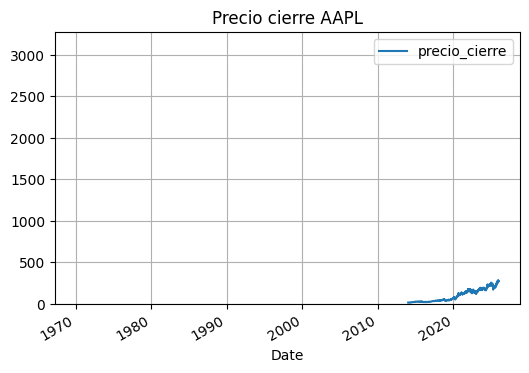

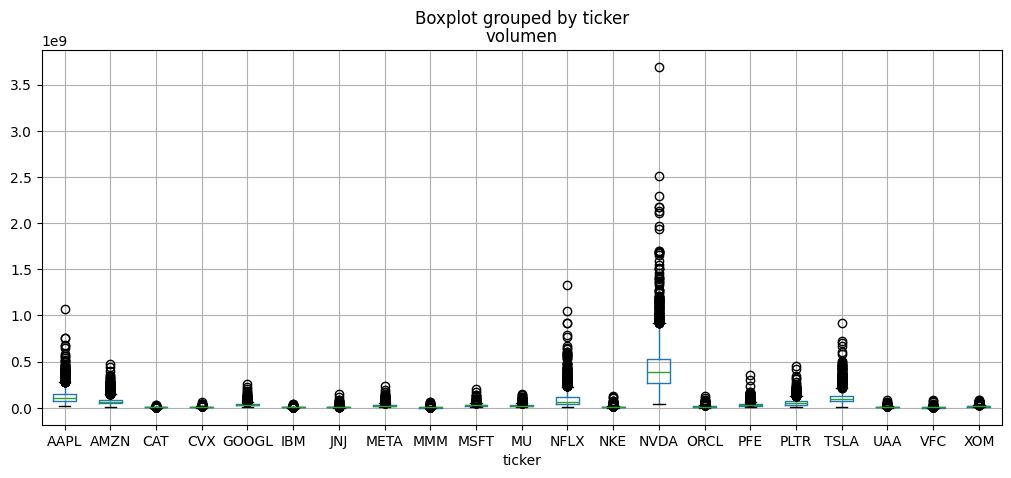

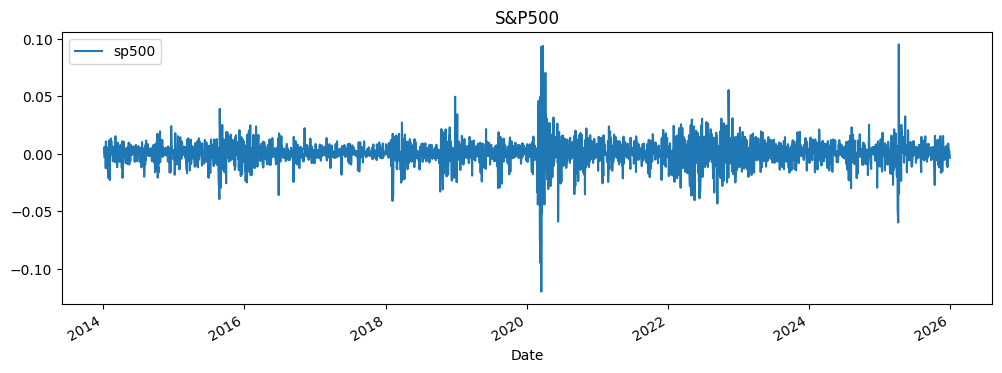

In [ ]:
df["ticker"].value_counts().plot(kind="bar", figsize=(10,4))
df[df["ticker"]=="AAPL"].plot(
    x="Date",
    y="precio_cierre",
    figsize=(12,4),
    title="Precio cierre AAPL")

np.log(df["volumen"]).hist(bins=50, figsize=(6,4))
df.boxplot(column="volumen", by="ticker", figsize=(12,5))
df.drop_duplicates("Date").plot(
    x="Date",
    y="sp500",
    figsize=(12,4),
    title="S&P500"
)


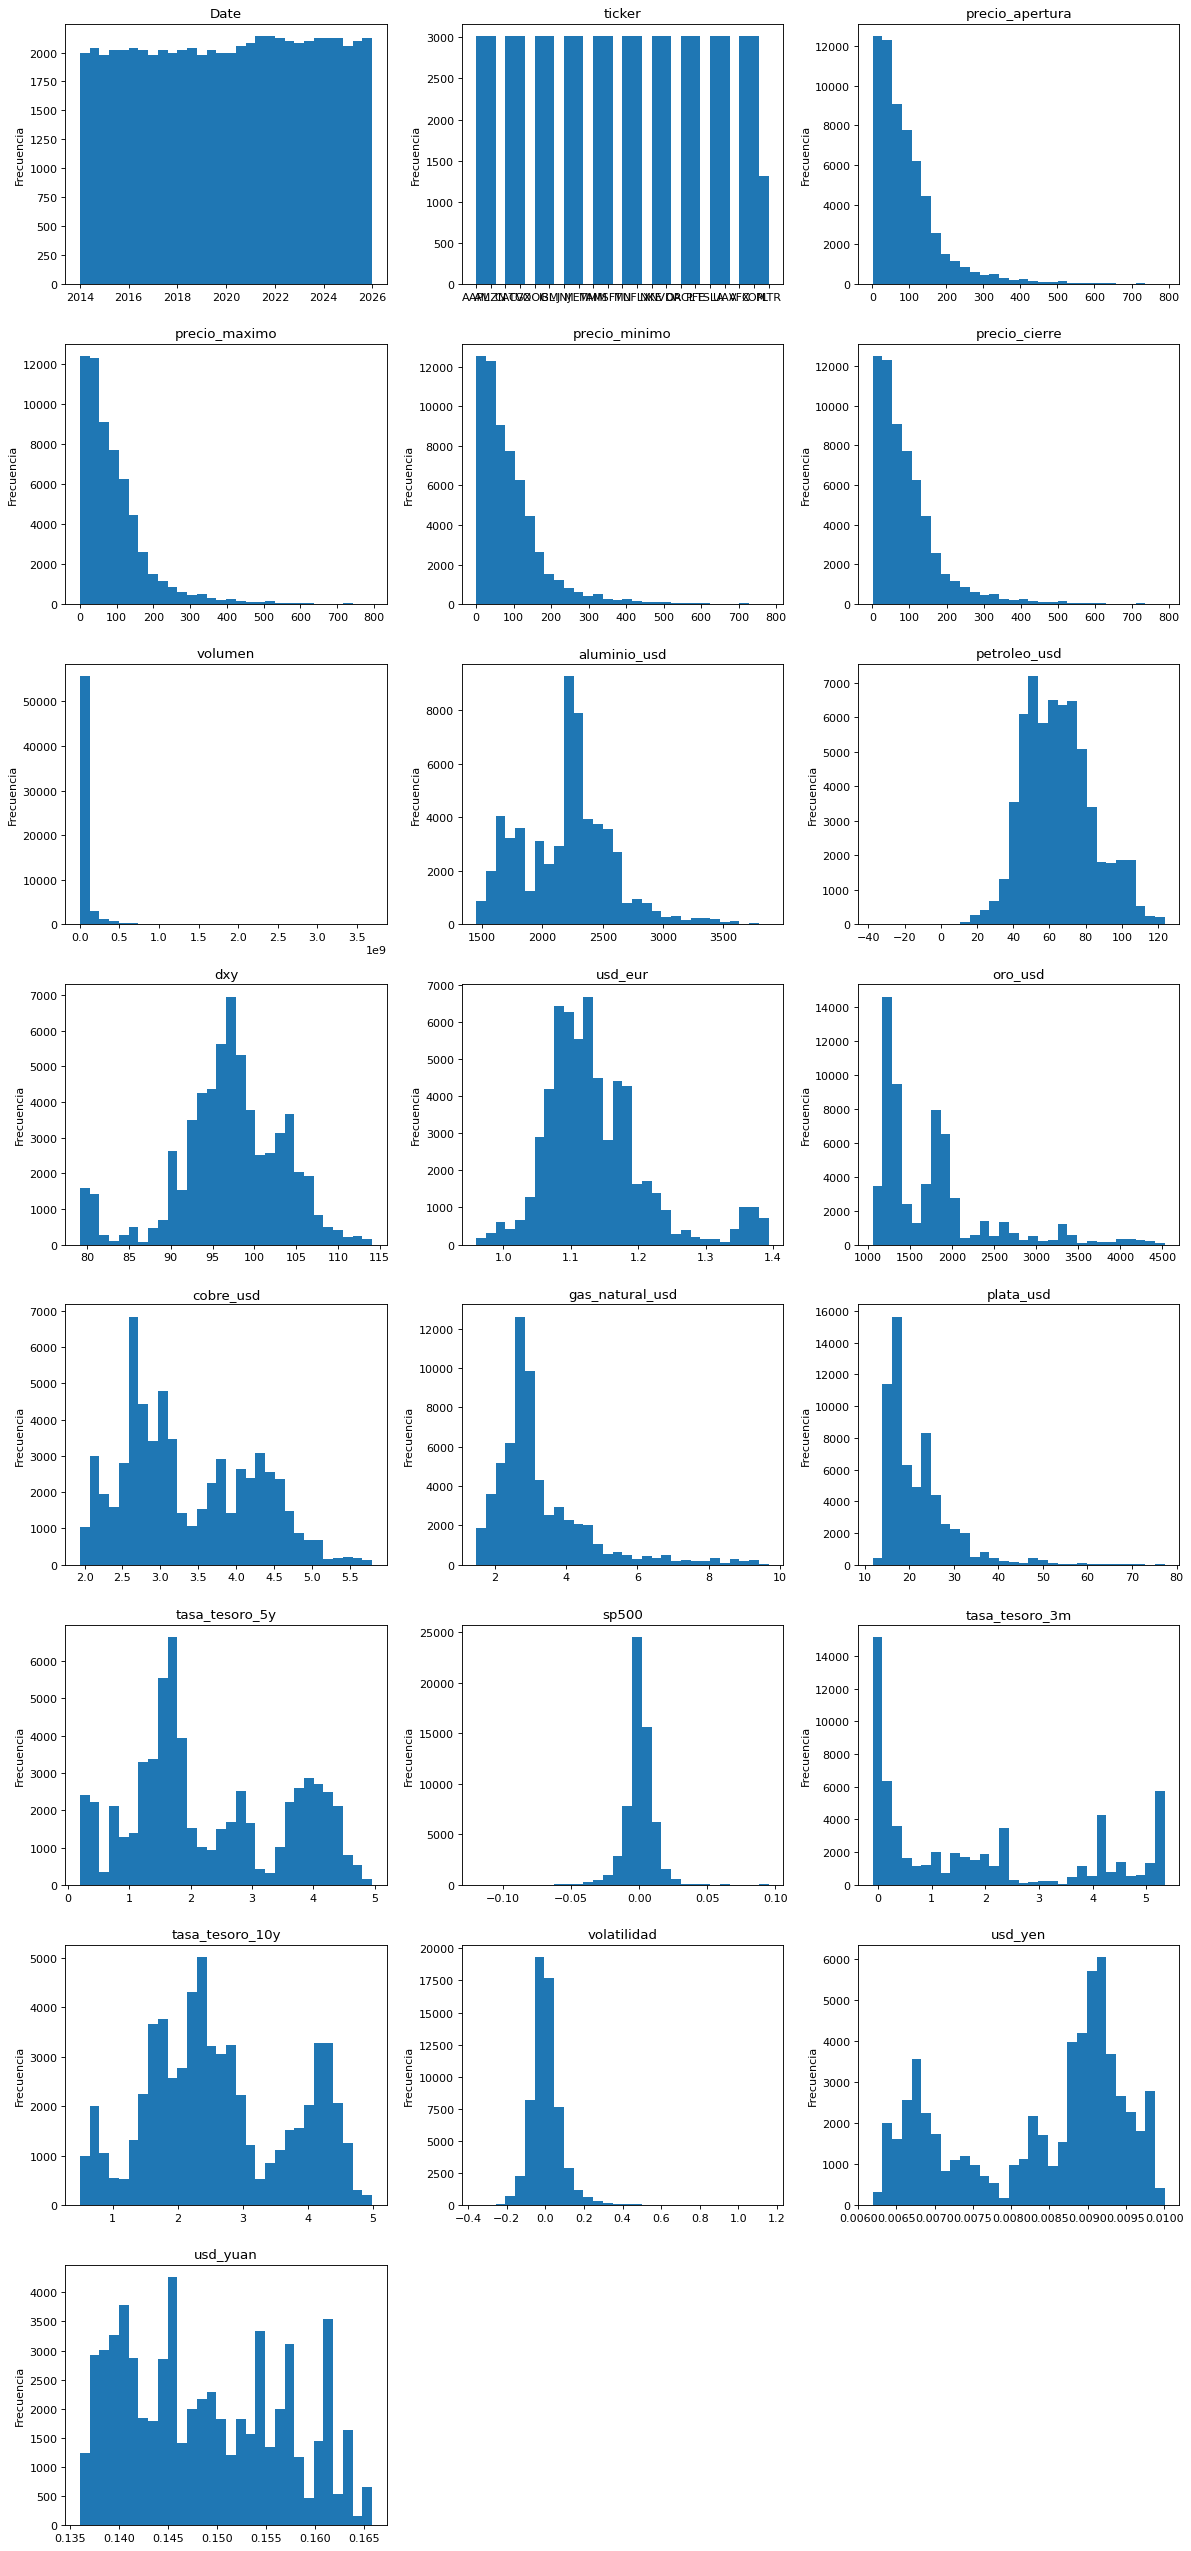

In [ ]:


n_cols = len(df.columns)
cols_per_row = 3
rows = math.ceil(n_cols / cols_per_row)

fig, axes = plt.subplots(
    rows,
    cols_per_row,
    figsize=(5 * cols_per_row, 4 * rows),
    dpi=80
)

axes = axes.flatten()

for i, col in enumerate(df.columns):
    axes[i].hist(
        df[col].dropna(),
        bins=30
    )
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frecuencia")

# Ocultar ejes vacíos
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


## **9. Validación Consistencia en los Datos**

##9.1 Primer Chequeo

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])

In [ ]:
df["weekday"] = df["Date"].dt.weekday

In [ ]:
df[df["weekday"] >= 5]

,Date,ticker,precio_apertura,precio_maximo,precio_minimo,precio_cierre,volumen,aluminio_usd,petroleo_usd,dxy,...,gas_natural_usd,plata_usd,tasa_tesoro_5y,sp500,tasa_tesoro_3m,tasa_tesoro_10y,volatilidad,usd_yen,usd_yuan,weekday


##9.2. Segundo Chequeo

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])

df = df.sort_values(["ticker", "Date"]).reset_index(drop=True)

In [ ]:
check = (
    df.groupby("ticker")["Date"]
      .apply(lambda s: s.diff().dt.days.value_counts())
)

check
check_df = check.unstack(fill_value=0)
check_df

AAPL,1.0,3.0,4.0,2.0
ticker,,,,
AAPL,2359,544,82,30
AMZN,2359,544,82,30
CAT,2359,544,82,30
CVX,2359,544,82,30
GOOGL,2359,544,82,30
IBM,2359,544,82,30
JNJ,2359,544,82,30
META,2359,544,82,30
MMM,2359,544,82,30


Las Diferencias de 1 son consistentes entre todas las acciones. A excepción de PLTR que es una Acción Nueva.

## 9.3. Chequeo de PLTR

In [ ]:
pltr_dates = (
    df[df["ticker"] == "PLTR"]
    .sort_values("Date")["Date"]
)

pltr_dates.min()

Timestamp('2020-09-30 00:00:00')

In [ ]:
pltr_check = (
    df[df["ticker"] == "PLTR"]
    .sort_values("Date")
    .groupby("ticker")["Date"]
    .apply(lambda s: s.diff().dt.days.value_counts())
)

pltr_check

ticker  PLTR
PLTR    1.0     1030
        3.0      237
        4.0       37
        2.0       14
Name: Date, dtype: int64

In [ ]:
start_pltr = pltr_dates.min()

compare = (
    df[df["Date"] >= start_pltr]
    .groupby("ticker")["Date"]
    .apply(lambda s: s.diff().dt.days.value_counts())
    .unstack(fill_value=0)
)

compare.loc[["PLTR", "AAPL", "MSFT"]]

AAPL,1.0,3.0,4.0,2.0
ticker,,,,
PLTR,1030,237,37,14
AAPL,1030,237,37,14
MSFT,1030,237,37,14


## **10. Cribado Manual**

## 10.1 Reemplazar Valores Atipicos por NAN.

In [ ]:
df.drop('weekday', axis=1, inplace=True)

In [ ]:
acciones = (
    df
    .pivot(index="Date", columns="ticker", values="precio_cierre")
    .sort_index()
)
commodities = exo_final[[
    "oro_usd",
    "plata_usd",
    "petroleo_usd",
    "gas_natural_usd",
    "cobre_usd",
    "aluminio_usd",
    "sp500",
    "tasa_tesoro_10y",
    "tasa_tesoro_5y",
    "tasa_tesoro_3m",
    "volatilidad",
    "dxy",
    "usd_eur",
    "usd_yen",
    "usd_yuan"


]].sort_index()
acciones_norm = acciones.apply(lambda s: s / s.dropna().iloc[0] * 100)
commodities_norm = commodities.apply(lambda s: s / s.dropna().iloc[0] * 100)


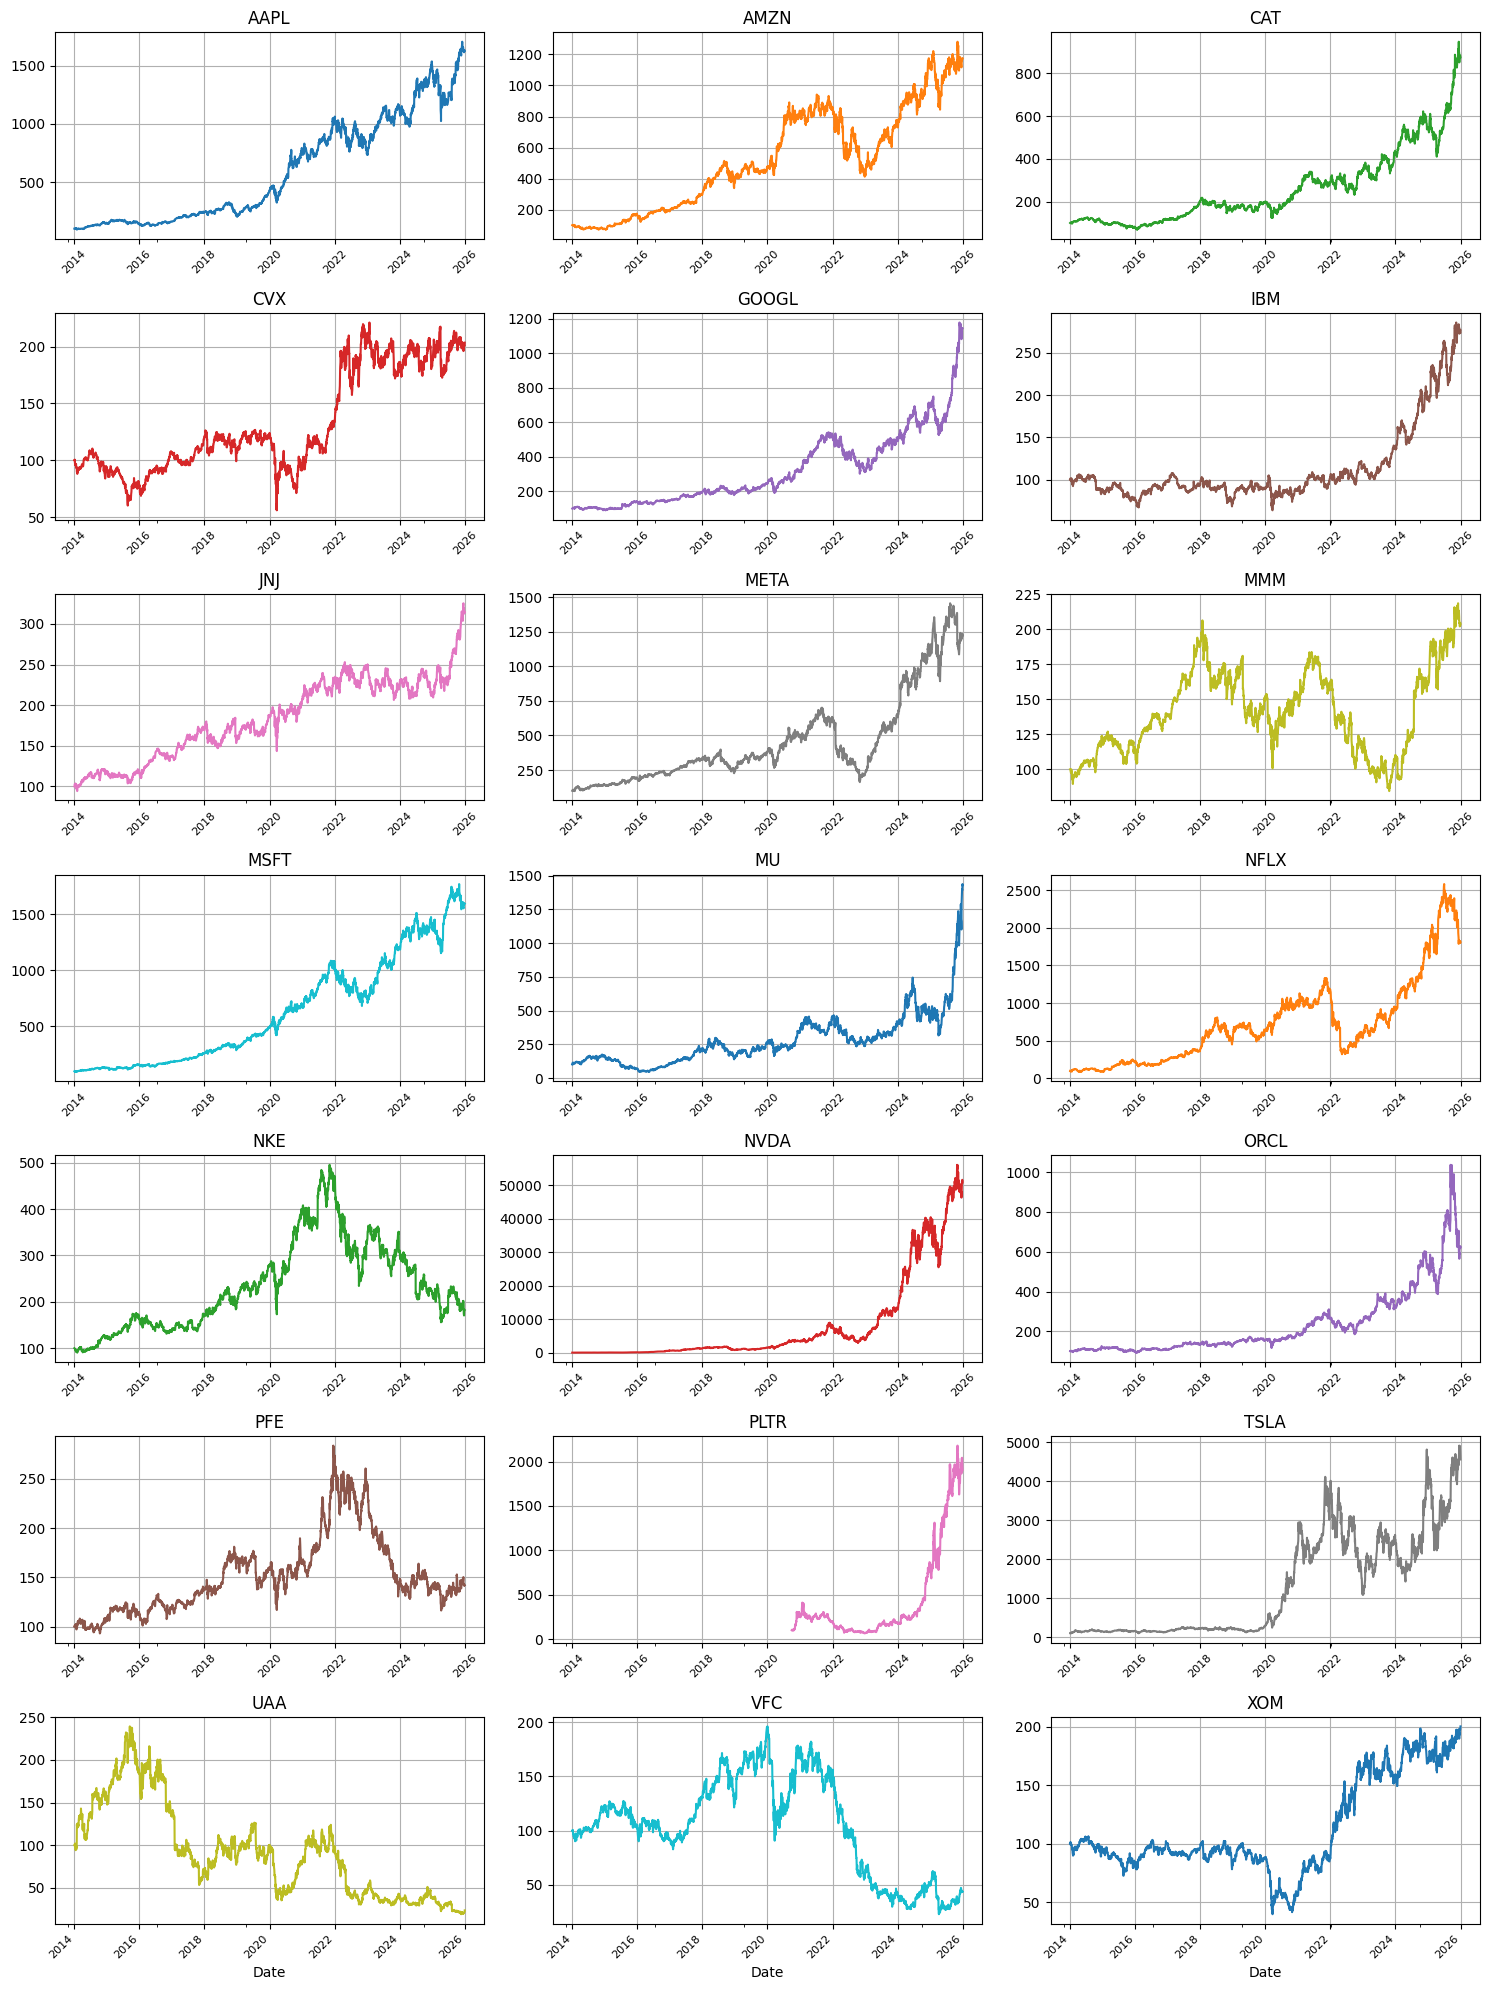

In [ ]:
import matplotlib.dates as mdates
axes = acciones_norm.plot(
    subplots=True,
    layout=(7, 3),
    figsize=(15, 20),
    legend=False,
    grid=True
)

axes = axes.flatten()

for ax, col in zip(axes, acciones_norm.columns):
    ax.set_title(col)
    ax.tick_params(axis="x", labelrotation=45, labelsize=8, labelbottom=True)
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.show()

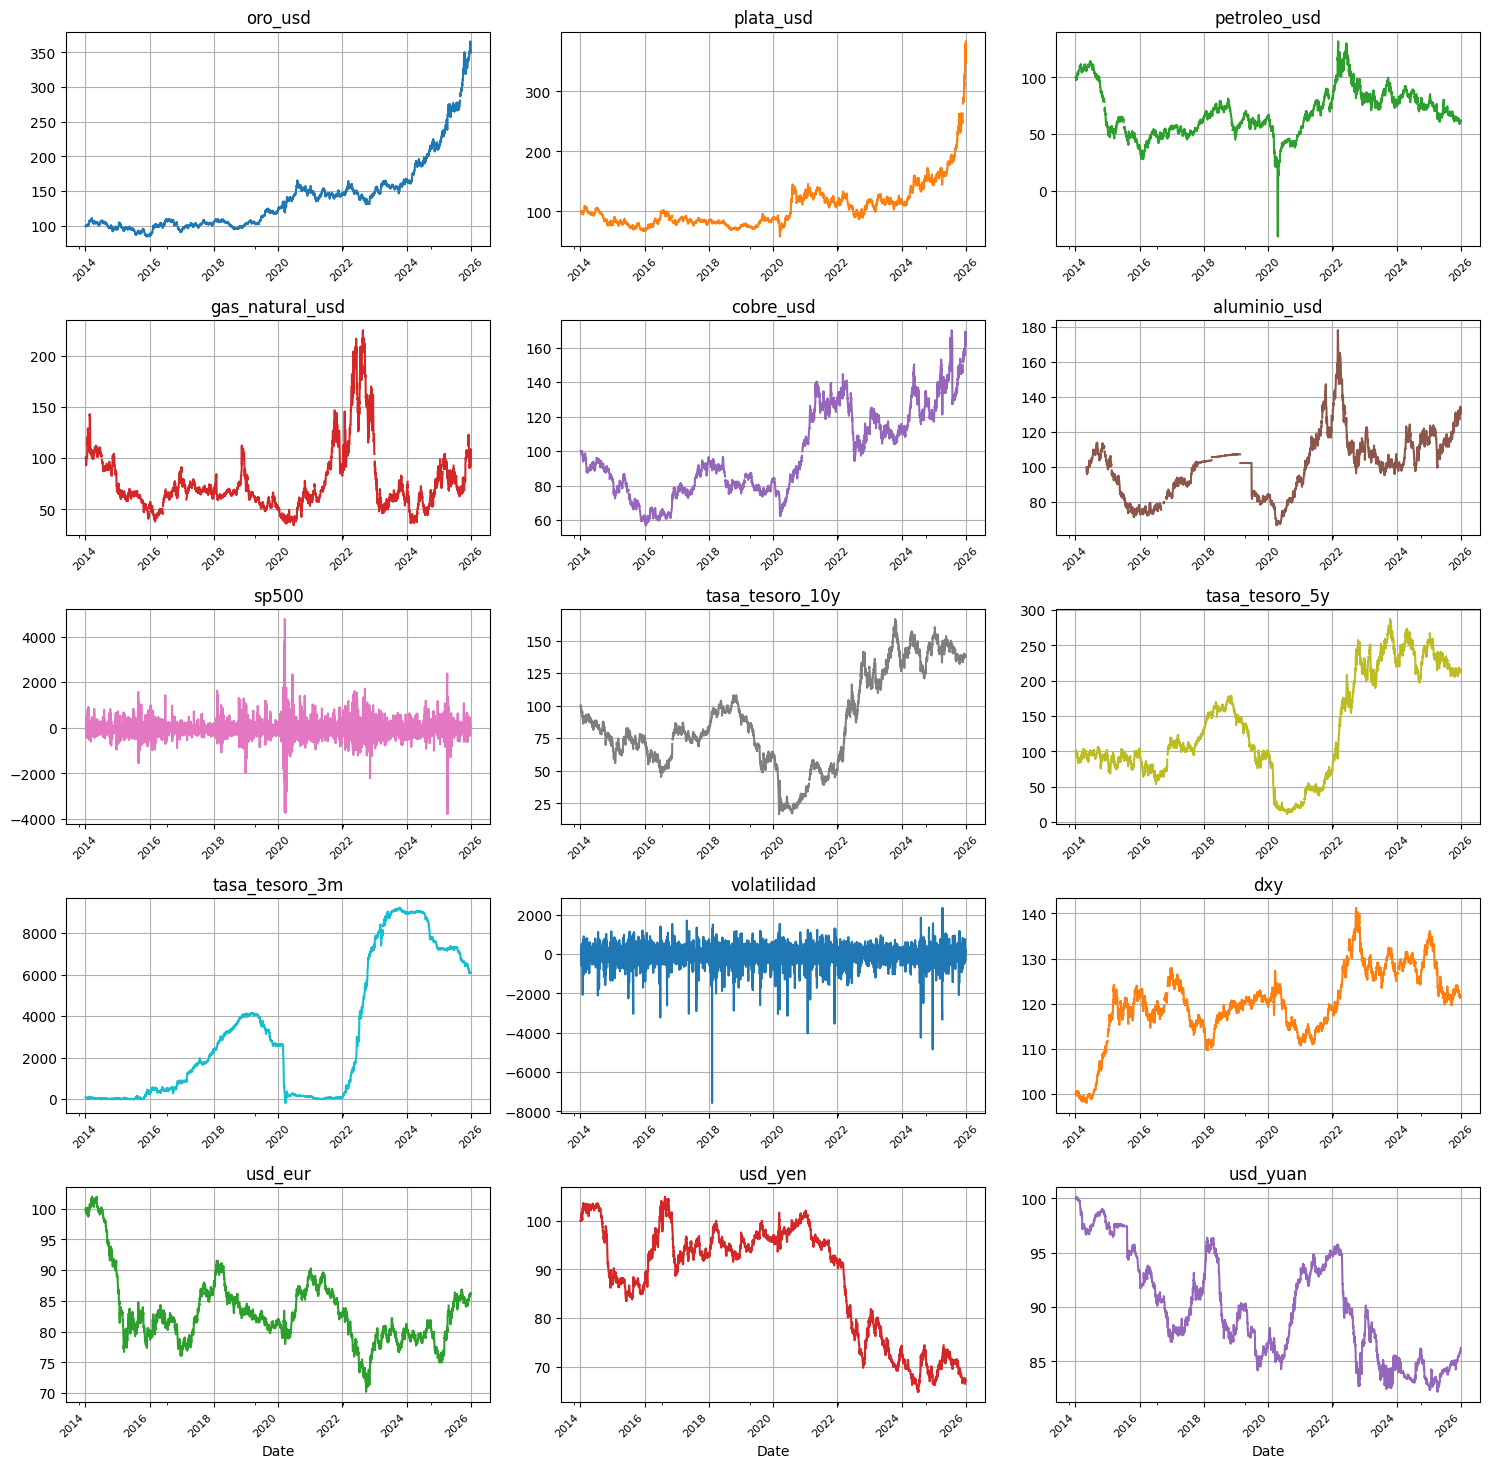

In [ ]:
axes = commodities_norm.plot(
    subplots=True,
    layout=(7, 3),
    figsize=(15, 20),
    legend=False,
    grid=True
)

axes = axes.flatten()

for ax, col in zip(axes, commodities_norm.columns):
    ax.set_title(col)
    ax.tick_params(axis="x", labelrotation=45, labelsize=8, labelbottom=True)
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.show()

## 10.2 Identificar columnas con columnas constantes

In [ ]:
unicos = df.nunique()
df[unicos[unicos==1].index]
df[unicos[unicos==1].index].head(5)

""
0
1
2
3
4


## 10.3. Eliminamos filas y columnas duplicadas.

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df[df.duplicated(keep=False)]


,Date,ticker,precio_apertura,precio_maximo,precio_minimo,precio_cierre,volumen,aluminio_usd,petroleo_usd,dxy,...,cobre_usd,gas_natural_usd,plata_usd,tasa_tesoro_5y,sp500,tasa_tesoro_3m,tasa_tesoro_10y,volatilidad,usd_yen,usd_yuan


In [ ]:
df.T.duplicated().sum()

np.int64(0)

In [ ]:
df.T.duplicated(keep=False)

,0
Date,False
ticker,False
precio_apertura,False
precio_maximo,False
precio_minimo,False
precio_cierre,False
volumen,False
aluminio_usd,False
petroleo_usd,False
dxy,False


## 10.4 Eliminar Columnas redundantes.

In [ ]:
pd.set_option('display.max_columns', None)
df.head(10)

,Date,ticker,precio_apertura,precio_maximo,precio_minimo,precio_cierre,volumen,aluminio_usd,petroleo_usd,dxy,usd_eur,oro_usd,cobre_usd,gas_natural_usd,plata_usd,tasa_tesoro_5y,sp500,tasa_tesoro_3m,tasa_tesoro_10y,volatilidad,usd_yen,usd_yuan
0,2014-01-03,AAPL,17.148328,17.174382,16.762780,16.779840,392467600.0,NaN,93.959999,80.790001,1.366662,1238.400024,3.4060,4.304,20.181999,1.727,NaN,0.058,2.995,NaN,0.009539,0.165544
1,2014-01-06,AAPL,16.670349,16.960361,16.550931,16.871342,412610800.0,NaN,93.430000,80.650002,1.359601,1237.800049,3.4120,4.306,20.077000,1.697,NaN,0.045,2.961,NaN,0.009532,0.165522
2,2014-01-07,AAPL,16.883443,16.934311,16.684932,16.750689,317209200.0,NaN,93.669998,80.830002,1.363196,1229.400024,3.4110,4.299,19.764999,1.674,-0.002512,0.043,2.937,-0.015262,0.009596,0.165489
3,2014-01-08,AAPL,16.712531,16.921900,16.708811,16.856764,258529600.0,NaN,92.330002,81.040001,1.361637,1225.300049,3.3935,4.216,19.518000,1.760,0.006082,0.040,2.993,-0.046494,0.009550,0.165530
4,2014-01-09,AAPL,16.960367,16.962229,16.605217,16.641508,279148800.0,NaN,91.660004,81.010002,1.357202,1229.300049,3.3540,4.005,19.663000,1.745,-0.000212,0.033,2.963,-0.003870,0.009538,0.165527
5,2014-01-10,AAPL,16.744168,16.774256,16.473696,16.530458,304976000.0,NaN,92.720001,80.660004,1.360711,1246.699951,3.3870,4.053,20.201000,1.623,0.000348,0.033,2.860,0.001554,0.009539,0.165426
6,2014-01-13,AAPL,16.436479,16.826988,16.435548,16.617001,378492800.0,NaN,91.800003,80.510002,1.367185,1250.900024,3.4000,4.274,20.361000,1.589,0.002307,0.030,2.827,-0.058185,0.009620,0.165503
7,2014-01-14,AAPL,16.694230,16.958189,16.676860,16.947643,332561600.0,NaN,92.589996,80.610001,1.366998,1245.199951,3.3880,4.369,20.250999,1.647,-0.012576,0.033,2.869,0.093904,0.009698,0.165747
8,2014-01-15,AAPL,17.168800,17.375997,17.111107,17.287907,391638800.0,NaN,94.169998,81.000000,1.366848,1238.099976,3.4065,4.325,20.103001,1.673,0.010818,0.035,2.884,-0.075301,0.009599,0.165804
9,2014-01-16,AAPL,17.211602,17.272086,17.111724,17.191441,229278000.0,NaN,93.959999,80.900002,1.359934,1240.000000,3.3910,4.382,20.025000,1.643,0.005166,0.030,2.843,0.000000,0.009563,0.165673


## **11. Valores Faltantes por Columnas**

In [ ]:
df.shape

(61639, 22)

In [ ]:
faltantes = df.isna().mean()*100
faltantes[faltantes>0]

,0
aluminio_usd,3.958533
petroleo_usd,0.064894
dxy,0.064894
usd_eur,0.131410
oro_usd,0.097341
cobre_usd,0.097341
gas_natural_usd,0.064894
plata_usd,0.097341
tasa_tesoro_5y,0.032447
sp500,0.064894


## **12. Valores Faltantes por Filas**

In [ ]:
df.isnull().any(axis=1).sum()

np.int64(2541)

In [ ]:
n = 2
df[df.isnull().sum(axis=1) ==n]

,Date,ticker,precio_apertura,precio_maximo,precio_minimo,precio_cierre,volumen,aluminio_usd,petroleo_usd,dxy,usd_eur,oro_usd,cobre_usd,gas_natural_usd,plata_usd,tasa_tesoro_5y,sp500,tasa_tesoro_3m,tasa_tesoro_10y,volatilidad,usd_yen,usd_yuan


In [ ]:
n = 3
df[df.isnull().sum(axis=1) ==n]

,Date,ticker,precio_apertura,precio_maximo,precio_minimo,precio_cierre,volumen,aluminio_usd,petroleo_usd,dxy,usd_eur,oro_usd,cobre_usd,gas_natural_usd,plata_usd,tasa_tesoro_5y,sp500,tasa_tesoro_3m,tasa_tesoro_10y,volatilidad,usd_yen,usd_yuan
0,2014-01-03,AAPL,17.148328,17.174382,16.762780,16.779840,392467600.0,NaN,93.959999,80.790001,1.366662,1238.400024,3.4060,4.304,20.181999,1.727,NaN,0.058,2.995,NaN,0.009539,0.165544
1,2014-01-06,AAPL,16.670349,16.960361,16.550931,16.871342,412610800.0,NaN,93.430000,80.650002,1.359601,1237.800049,3.4120,4.306,20.077000,1.697,NaN,0.045,2.961,NaN,0.009532,0.165522
885,2017-07-11,AAPL,33.641077,33.901413,33.559725,33.827030,79127200.0,1961.75,45.040001,95.739998,NaN,1213.599976,2.6645,3.047,15.697000,1.919,0.000928,1.033,2.362,-0.007149,NaN,NaN
976,2017-11-16,AAPL,40.088968,40.250561,39.882882,40.070236,94550000.0,2231.50,55.139999,93.930000,NaN,1277.400024,3.0435,3.053,17.056000,2.065,-0.005526,1.230,2.361,0.132873,NaN,NaN
1354,2019-05-22,AAPL,44.253149,44.504779,43.747495,43.802612,118994400.0,2225.00,61.419998,98.110001,NaN,1273.599976,2.6860,2.543,14.414000,2.189,0.008496,2.320,2.393,-0.083384,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58624,2014-01-06,XOM,60.633620,60.754959,59.996583,60.463745,11848500.0,NaN,93.430000,80.650002,1.359601,1237.800049,3.4120,4.306,20.077000,1.697,NaN,0.045,2.961,NaN,0.009532,0.165522
59508,2017-07-11,XOM,54.670503,54.956343,54.473136,54.854256,9681100.0,1961.75,45.040001,95.739998,NaN,1213.599976,2.6645,3.047,15.697000,1.919,0.000928,1.033,2.362,-0.007149,NaN,NaN
59599,2017-11-16,XOM,55.787587,56.071932,55.586463,55.870808,10527200.0,2231.50,55.139999,93.930000,NaN,1277.400024,3.0435,3.053,17.056000,2.065,-0.005526,1.230,2.361,0.132873,NaN,NaN
59977,2019-05-22,XOM,56.153054,56.300790,55.687699,55.813271,7858300.0,2225.00,61.419998,98.110001,NaN,1273.599976,2.6860,2.543,14.414000,2.189,0.008496,2.320,2.393,-0.083384,NaN,NaN


In [ ]:
n = 4
df[df.isnull().sum(axis=1) ==n]

,Date,ticker,precio_apertura,precio_maximo,precio_minimo,precio_cierre,volumen,aluminio_usd,petroleo_usd,dxy,usd_eur,oro_usd,cobre_usd,gas_natural_usd,plata_usd,tasa_tesoro_5y,sp500,tasa_tesoro_3m,tasa_tesoro_10y,volatilidad,usd_yen,usd_yuan
1024,2018-01-29,AAPL,39.850087,39.850087,39.126435,39.334866,202561600.0,NaN,65.559998,89.309998,1.242807,NaN,NaN,3.631,NaN,2.495,0.011841,1.375,2.699,-0.043178,0.009205,0.158331
4040,2018-01-29,AMZN,70.459000,71.569504,70.022003,70.884003,114038000.0,NaN,65.559998,89.309998,1.242807,NaN,NaN,3.631,NaN,2.495,0.011841,1.375,2.699,-0.043178,0.009205,0.158331
7056,2018-01-29,CAT,139.341082,139.593545,134.157234,136.816483,9496800.0,NaN,65.559998,89.309998,1.242807,NaN,NaN,3.631,NaN,2.495,0.011841,1.375,2.699,-0.043178,0.009205,0.158331
10072,2018-01-29,CVX,92.083289,93.159461,90.851365,90.964638,6350700.0,NaN,65.559998,89.309998,1.242807,NaN,NaN,3.631,NaN,2.495,0.011841,1.375,2.699,-0.043178,0.009205,0.158331
13088,2018-01-29,GOOGL,58.954554,59.450804,58.759029,58.879124,31494000.0,NaN,65.559998,89.309998,1.242807,NaN,NaN,3.631,NaN,2.495,0.011841,1.375,2.699,-0.043178,0.009205,0.158331
16104,2018-01-29,IBM,112.902500,113.536295,111.931582,112.464241,3678782.0,NaN,65.559998,89.309998,1.242807,NaN,NaN,3.631,NaN,2.495,0.011841,1.375,2.699,-0.043178,0.009205,0.158331
19120,2018-01-29,JNJ,115.847784,115.919761,114.792071,114.912033,8013400.0,NaN,65.559998,89.309998,1.242807,NaN,NaN,3.631,NaN,2.495,0.011841,1.375,2.699,-0.043178,0.009205,0.158331
22136,2018-01-29,META,187.440654,187.530026,184.342302,184.689865,20453200.0,NaN,65.559998,89.309998,1.242807,NaN,NaN,3.631,NaN,2.495,0.011841,1.375,2.699,-0.043178,0.009205,0.158331
25152,2018-01-29,MMM,163.337772,163.862194,161.732888,161.758163,2758335.0,NaN,65.559998,89.309998,1.242807,NaN,NaN,3.631,NaN,2.495,0.011841,1.375,2.699,-0.043178,0.009205,0.158331
28168,2018-01-29,MSFT,87.502658,87.787771,86.196650,86.380592,31569900.0,NaN,65.559998,89.309998,1.242807,NaN,NaN,3.631,NaN,2.495,0.011841,1.375,2.699,-0.043178,0.009205,0.158331


In [ ]:
n = 5
df[df.isnull().sum(axis=1) ==n]

,Date,ticker,precio_apertura,precio_maximo,precio_minimo,precio_cierre,volumen,aluminio_usd,petroleo_usd,dxy,usd_eur,oro_usd,cobre_usd,gas_natural_usd,plata_usd,tasa_tesoro_5y,sp500,tasa_tesoro_3m,tasa_tesoro_10y,volatilidad,usd_yen,usd_yuan


<Axes: >

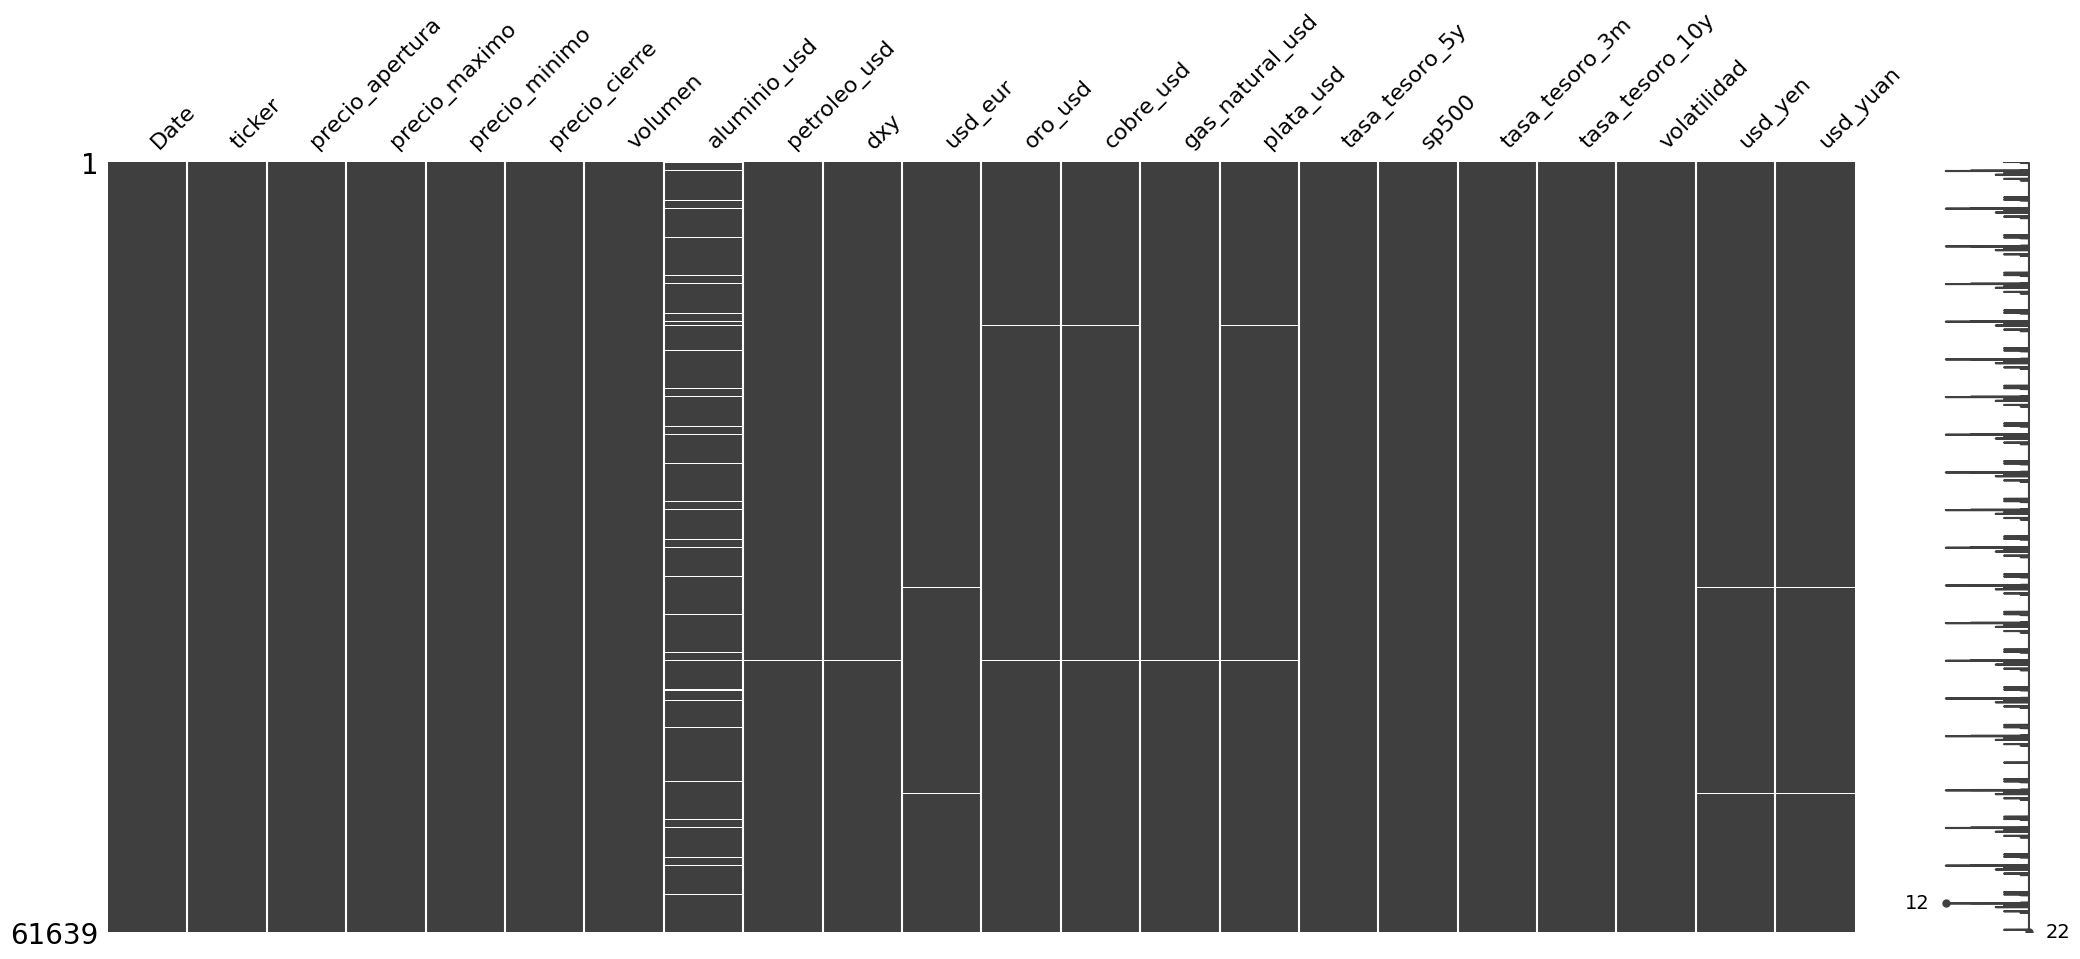

In [ ]:
msno.matrix(df)

## **13. Identificación de problemas de calidad de datos, por alto nivel de NAN: aluminio_usd**

In [ ]:
df.loc[df["aluminio_usd"].isna()] \
  .assign(year=lambda x: x["Date"].dt.year) \
  .groupby(["ticker", "year"]) \
  .size() \
  .unstack(fill_value=0)

year,2014,2016,2017,2018
ticker,,,,
AAPL,84,34,3,1
AMZN,84,34,3,1
CAT,84,34,3,1
CVX,84,34,3,1
GOOGL,84,34,3,1
IBM,84,34,3,1
JNJ,84,34,3,1
META,84,34,3,1
MMM,84,34,3,1


Comienza a Cotizar tarde.

## **14. Guardar Dataset**

In [ ]:
dump(df, "dataset.csv")

['dataset.csv']